# Polarization CLEAN in a bottle
______________________________________________________________________________

Algorithm: Pratley, Luke and Johnston-Hollit Melanie, An improved method for 
polarimetric image restoration in interferometry, 2016

Implementation (C) B Hugo, SKA-SA

Credit: L Bester's Hogbom CLEAN implementation, SKA-SA
______________________________________________________________________________

In [1]:
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from pyrap.tables import table as tbl
import scipy.signal
import time
from IPython.display import clear_output
from IPython.html.widgets import FloatProgress
from IPython.display import display
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import optimize as opt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#(C) Landman Bester
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (cos(theta)**2)/(2*sigma_x**2) + (sin(theta)**2)/(2*sigma_y**2)
    b = -(sin(2*theta))/(4*sigma_x**2) + (sin(2*theta))/(4*sigma_y**2)
    c = (sin(theta)**2)/(2*sigma_x**2) + (cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.flatten()

#(C) Landman Bester
def fit_2D_Gaussian(PSF):
    """
    Fit an elliptical Gaussian to the primary lobe of the PSF
    """
    #Get the full width at half maximum height of the PSF
    I = argwhere(PSF>=0.5*PSF.max())
    #Create an array with these values at the same indices and zeros otherwise
    lk,mk = PSF.shape
    psf_fit = zeros([lk,mk])
    psf_fit[I[:,0],I[:,1]] = PSF[I[:,0],I[:,1]]
    # Create x and y indices
    x = linspace(0, PSF.shape[0]-1, PSF.shape[0])
    y = linspace(0, PSF.shape[1]-1, PSF.shape[1])
    x, y = meshgrid(x, y)
    # Set starting point of optimiser
    initial_guess = (0.5,lk/2,mk/2,1.75,1.4,-4.0,0)
    #Flatten the data
    data = psf_fit.ravel()
    #Fit the function (Gaussian for now)
    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)
    #Get function with fitted params
    data_fitted = twoD_Gaussian((x, y), *popt)
    #Normalise the psf to have a max value of one
    data_fitted = data_fitted/data_fitted.max()
    return data_fitted.reshape(lk,mk)


In [88]:
def find_peak(Iresidue,Qresidue,Uresidue,Vresidue,mode="I"):
    """
    Finds peak in image or combination of images depending on mode
    Q+iU: Luke Pratley's joint linear (P) polarization clean
    I: Intensity only
    """
    if mode == "Q+iU":
        values_map = Qresidue + Uresidue*1.0j
        peakmap = (np.abs(values_map))**2
        p,q = (argwhere(peakmap==peakmap.max())[0]).squeeze()
        pmin,qmin = (argwhere(peakmap==peakmap.min())[0]).squeeze()
        Istar = values_map[p,q] #in Q and U the values may be negative or positive
    elif mode == "Q":
        peakmap = abs(Qresidue)
        p,q = (argwhere(peakmap==peakmap.max())[0]).squeeze()
        pmin,qmin = (argwhere(peakmap==peakmap.min())[0]).squeeze()
        Istar = Qresidue[p,q]
    elif mode == "U":
        peakmap = abs(Uresidue)
        p,q = (argwhere(peakmap==peakmap.max())[0]).squeeze()
        pmin,qmin = (argwhere(peakmap==peakmap.min())[0]).squeeze()
        Istar = Uresidue[p,q]
    elif mode == "I":
        peakmap = Iresidue
        p,q = (argwhere(peakmap==peakmap.max())[0]).squeeze()
        pmin,qmin = (argwhere(peakmap==peakmap.min())[0]).squeeze()
        Istar = Iresidue[p,q]
    else:
        raise ValueError("Peakfinding only works for mode one of [Q+iU, I]")
    return p,q,pmin,qmin,Istar

def build_cleanmap(ICLEAN,QCLEAN,UCLEAN,VCLEAN,Istar,gamma,p,q,mode="I"):
    if mode == "Q+iU":
        QCLEAN[p,q] += Istar.real*gamma
        UCLEAN[p,q] += Istar.imag*gamma
    elif mode == "Q":
        QCLEAN[p,q] += Istar*gamma
    elif mode == "U":
        UCLEAN[p,q] += Istar*gamma
    elif mode == "I":
        ICLEAN[p,q] += Istar*gamma
    else:
        raise ValueError("Cleanmap building only works for mode one of [Q+iU, I]")
        
def update_residual(Iresidue,Qresidue,Uresidue,Vresidue,Istar,gamma,p,q,PSF,mode="I"):
    if mode == "Q+iU":
        npix = Iresidue.shape[0] #Assuming square image
        Qresidue -= gamma*Istar.real*PSF[npix - p:2*npix - p,
                                         npix - q:2*npix - q] 
        Uresidue -= gamma*Istar.imag*PSF[npix - p:2*npix - p,
                                         npix - q:2*npix - q]
    elif mode == "Q":
        npix = Iresidue.shape[0] #Assuming square image
        Qresidue -= gamma*Istar*PSF[npix - p:2*npix - p,
                                    npix - q:2*npix - q] 
    elif mode == "U":
        npix = Iresidue.shape[0] #Assuming square image
        Uresidue -= gamma*Istar*PSF[npix - p:2*npix - p,
                                    npix - q:2*npix - q] 
    elif mode == "I":
        npix = Iresidue.shape[0] #Assuming square image
        Iresidue -= gamma*Istar*PSF[npix - p:2*npix - p,
                                    npix - q:2*npix - q] 
    else:
        raise ValueError("Residual subtraction only works for mode one of [Q+iU, I]")
        
def convolve_model(CLEAN_BEAM,ICLEAN,QCLEAN,UCLEAN,VCLEAN,mode):
    ICONV_MODEL = np.zeros(ICLEAN.shape)
    QCONV_MODEL = np.zeros(ICLEAN.shape)
    UCONV_MODEL = np.zeros(ICLEAN.shape)
    VCONV_MODEL = np.zeros(ICLEAN.shape)
    if mode == "Q+iU":
        QCONV_MODEL[:,:] = scipy.signal.fftconvolve(QCLEAN,CLEAN_BEAM,mode='same') #, cval=0.0) #Fast using fft
        UCONV_MODEL[:,:] = scipy.signal.fftconvolve(UCLEAN,CLEAN_BEAM,mode='same') #, cval=0.0) #Fast using fft
    elif mode == "Q":
        QCONV_MODEL[:,:] = scipy.signal.fftconvolve(QCLEAN,CLEAN_BEAM,mode='same') #, cval=0.0) #Fast using fft
    elif mode == "U":
        UCONV_MODEL[:,:] = scipy.signal.fftconvolve(UCLEAN,CLEAN_BEAM,mode='same') #, cval=0.0) #Fast using fft
    elif mode == "I":
        ICONV_MODEL[:,:] = scipy.signal.fftconvolve(ICLEAN,CLEAN_BEAM,mode='same') #, cval=0.0) #Fast using fft
    else:
        raise ValueError("Convolve model only works for mode one of [Q+iU, I]")
    return ICONV_MODEL, QCONV_MODEL, UCONV_MODEL, VCONV_MODEL

def CLEAN_HOG(IDIRTY,QDIRTY,UDIRTY,VDIRTY,
              PSF,gamma = 0.1,threshold = "Default", niter = "Default", 
              plot_on=True, mode="I"):
    """
    This is a simple Hogbom CLEAN assuming a full cleaning window
    Input: IDirty = the dirty image to be cleaned
    PSF = the point spread function
    gamma = the gain factor (must be less than one)
    theshold = the threshold to clean up to
    niter = the maximum number of iterations allowed
    Output: ICLEAN = Clean model, IRESIDUAL = Residuals, 
            IRESTORE = Restored map, ICONV_CLEAN = Clean model convolved with clean beam
    
    """
    #deep copy dirties to first residues, want to keep the original dirty maps
    ID = np.copy(IDIRTY)
    QD = np.copy(QDIRTY) 
    UD = np.copy(UDIRTY) 
    VD = np.copy(VDIRTY) 
    #Check that all the dirty maps have the same shape
    if (ID.shape[0] != QD.shape[0] or QD.shape[0] != UD.shape[0] or UD.shape[0] != VD.shape[0] or
        ID.shape[1] != QD.shape[1] or QD.shape[1] != UD.shape[1] or UD.shape[1] != VD.shape[1]):
            raise ValueError("Polarized dirties must have the same shape")
    #Check that PSF is twice the size of ID
    if PSF.shape[0] != 2*ID.shape[0] or PSF.shape[1] != 2*ID.shape[1]:
        raise ValueError("Warning PSF not right size")
    #Initialise array to store cleaned image
    ICLEAN = zeros([npix,npix])
    QCLEAN = zeros([npix,npix])
    UCLEAN = zeros([npix,npix])
    VCLEAN = zeros([npix,npix])

    if niter == "Default":
        niter = 3*npix

    p,q,pmin,qmin,Istar = find_peak(ID,QD,UD,VD,mode)
    if threshold=="Default":
        threshold = 0.2*np.abs(Istar) #Imin + 0.001*(Istar - Imin)
        print "Threshold set at ", threshold
    else:
        print "Assuming user set threshold"

    #CLEAN the image
    i = 0 #counter index
    pbar_clean = FloatProgress(min=0, max=100)
    display(pbar_clean)

    while np.abs(Istar) > threshold and i <= niter:
        #First we set the
        build_cleanmap(ICLEAN,QCLEAN,UCLEAN,VCLEAN,Istar,gamma,p,q,mode)
        #Subtract out pixel
        update_residual(ID,QD,UD,VD,Istar,gamma,p,q,PSF,mode)
        #Get new indices where ID is max
        p,q,_,_,Istar = find_peak(ID,QD,UD,VD,mode)
        #Increment counter
        i += 1
        #Warn if niter exceeded
        if i > niter:
            print "Warning: number of iterations exceeded"
            print "Minimum ID = ", ID.max()
        pbar_clean.value = i / float(niter) * 100.0
    pbar_clean.value = 100 # done
    print "Done cleaning for mode %s after %d iterations. Now restoring..." % (mode,i)
    #get the ideal beam (fit 2D Gaussian to HWFH of PSF)
    CLEAN_BEAM = fit_2D_Gaussian(PSF)
    
    #Now convolve ICLEAN with ideal beam
    ICONV_MODEL, QCONV_MODEL, UCONV_MODEL, VCONV_MODEL = convolve_model(CLEAN_BEAM, ICLEAN, QCLEAN, UCLEAN, VCLEAN, mode)
    
    #Finally we add the residuals back to the image
    IRESIDUE = ID
    QRESIDUE = QD
    URESIDUE = UD
    VRESIDUE = VD
    
    IRESTORE = ICONV_MODEL + IRESIDUE
    QRESTORE = QCONV_MODEL + QRESIDUE
    URESTORE = UCONV_MODEL + URESIDUE
    VRESTORE = VCONV_MODEL + VRESIDUE
    
    return (ICLEAN, IRESIDUE, IRESTORE, ICONV_MODEL,QCLEAN, QRESIDUE, QRESTORE, QCONV_MODEL,
            UCLEAN, URESIDUE, URESTORE, UCONV_MODEL,VCLEAN, VRESIDUE, VRESTORE, VCONV_MODEL)
            
            

In [89]:
class AA_filter:
    """
    Anti-Aliasing filter
    
    Keyword arguments for __init__:
    filter_half_support --- Half support (N) of the filter; the filter has a full support of N*2 + 1 taps
    filter_oversampling_factor --- Number of spaces in-between grid-steps (improves gridding/degridding accuracy)
    filter_type --- box (nearest-neighbour), sinc or gaussian_sinc
    """
    half_sup = 0
    oversample = 0
    full_sup_wo_padding = 0
    full_sup = 0
    no_taps = 0
    filter_taps = None
    def __init__(self, filter_half_support, filter_oversampling_factor, filter_type):
        self.half_sup = filter_half_support
        self.oversample = filter_oversampling_factor
        self.full_sup_wo_padding = (filter_half_support * 2 + 1)
        self.full_sup = self.full_sup_wo_padding + 2 #+ padding
        self.no_taps = self.full_sup + (self.full_sup - 1) * (filter_oversampling_factor - 1)
        taps = np.arange(self.no_taps)/float(filter_oversampling_factor) - self.full_sup / 2
        if filter_type == "box":
            self.filter_taps = np.where((taps >= -0.5) & (taps <= 0.5),
                                        np.ones([len(taps)]),np.zeros([len(taps)]))
        elif filter_type == "sinc":
            self.filter_taps = np.sinc(taps)
        elif filter_type == "gaussian_sinc":
            alpha_1=1.55
            alpha_2=2.52
            self.filter_taps = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
        else:
            raise ValueError("Expected one of 'box','sinc' or 'gausian_sinc'")

In [202]:
def grid_ifft(vis,uvw,ref_lda,Nx,Ny,convolution_filter):
    """
    Convolutional gridder (continnuum)
    
    Keyword arguments:
    vis --- Visibilities as sampled by the interferometer
    uvw --- interferometer's scaled uvw coordinates. (Prerequisite: these uv points are already scaled by the simularity
            theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
            -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5
    ref_lda --- array of reference lambdas (size of vis channels)
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing filter object
    """
    assert vis.shape[1] == ref_lda.shape[0], (vis.shape[1], ref_lda.shape[0])
    filter_index = np.arange(-convolution_filter.half_sup,convolution_filter.half_sup+1)
    measurement_regular = np.zeros([vis.shape[2],Ny,Nx],dtype=np.complex) #one grid for the resampled visibilities
    #for deconvolution the PSF should be 2x size of the image (see Hogbom CLEAN for details):
    sampling_regular = np.zeros([2*Ny,2*Nx],dtype=np.complex) #one grid for the resampled sampling function
    
    pbar = FloatProgress(min=0, max=100)
    display(pbar)
    for r in range(0,uvw.shape[0]):
        pbar.value = r / float(uvw.shape[0]) * 100
        for c in range(vis.shape[1]):
            scaled_uv = uvw[r,:] / ref_lda[c] 
            disc_u = int(scaled_uv[0])
            disc_v = int(scaled_uv[1])
            frac_u_offset = int((convolution_filter.half_sup + 1 + (-scaled_uv[0] + disc_u)) * convolution_filter.oversample)
            frac_v_offset = int((convolution_filter.half_sup + 1 + (-scaled_uv[1] + disc_v)) * convolution_filter.oversample)
            disc_u_psf = int(scaled_uv[0]*2)
            disc_v_psf = int(scaled_uv[1]*2)
            frac_u_offset_psf = int((convolution_filter.half_sup + 1 + (-scaled_uv[0]*2 + disc_u_psf)) * convolution_filter.oversample)
            frac_v_offset_psf = int((convolution_filter.half_sup + 1 + (-scaled_uv[1]*2 + disc_v_psf)) * convolution_filter.oversample)
            if (disc_v + Ny // 2 + convolution_filter.half_sup >= Ny or 
                disc_u + Nx // 2 + convolution_filter.half_sup >= Nx or
                disc_v + Ny // 2 - convolution_filter.half_sup < 0 or 
                disc_u + Nx // 2 - convolution_filter.half_sup < 0): 
                continue
            for conv_v in filter_index:
                v_tap = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset]  
                v_tap_psf = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset_psf]  
                grid_pos_v = disc_v + conv_v + Ny // 2
                grid_pos_v_psf = disc_v_psf + conv_v + Ny
                for conv_u in filter_index:
                    u_tap = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset]
                    u_tap_psf = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset_psf]
                    conv_weight = v_tap * u_tap
                    conv_weight_psf = v_tap_psf * u_tap_psf
                    grid_pos_u = disc_u + conv_u + Ny // 2
                    grid_pos_u_psf = disc_u_psf + conv_u + Nx
                    for p in range(vis.shape[2]):
                        measurement_regular[p,grid_pos_v,grid_pos_u] += vis[r,c,p] * conv_weight
                    sampling_regular[grid_pos_v_psf,grid_pos_u_psf] += (1+0.0j) * conv_weight_psf
                    
    dirty = np.zeros(measurement_regular.shape,dtype=measurement_regular.dtype)
    psf = np.zeros(sampling_regular.shape,dtype=sampling_regular.dtype)
    
    for p in range(vis.shape[2]):
        dirty[p,:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular[p,:,:])))
    psf[:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sampling_regular[:,:])))
    return dirty,psf

# Compute Dirty

In [218]:
ms = tbl("/scratch/WORKSPACE/DDFacetTesting/data/polarized_sky.MS_p0/")
aa = AA_filter(3,63,"sinc")
c = 2.99792458e8
npix = 1025
ARCSEC2RAD = 4.8481e-6
delta_pix = 2 * ARCSEC2RAD
uv_scale = npix * delta_pix
nchan = 1
nrows = 5000 #-1 to select all
uvw = ms.getcol("UVW")[0:nrows,:] * uv_scale
vis = ms.getcol("DATA")[0:nrows,0:nchan,:]
ref_freq = np.linspace(1.140e9,1.340e9,vis.shape[1])
ref_lambda = c / ref_freq
dirty,psf = grid_ifft(vis,uvw,ref_lambda,npix,npix,aa)

Successful readonly open of default-locked table /scratch/WORKSPACE/DDFacetTesting/data/polarized_sky.MS_p0/: 25 columns, 255528 rows


# Correlations -> Stokes

In [219]:
I = np.real((dirty[0,:,:]+dirty[3,:,:])*0.5)
Q = np.real((dirty[0,:,:]-dirty[3,:,:])*0.5)
U = np.real((dirty[1,:,:]+dirty[2,:,:])*0.5)
V = np.imag((dirty[1,:,:]-dirty[2,:,:])*0.5)

#assume psf is the same for all polarizations:
I_PSF = np.abs(psf)
Q_PSF = np.abs(psf)
U_PSF = np.abs(psf)
V_PSF = np.abs(psf)

I /= (np.max(I_PSF)*4) #x4 because the N**2 FFT normalization factor on a square image double the size
Q /= (np.max(Q_PSF)*4)
U /= (np.max(U_PSF)*4)
V /= (np.max(V_PSF)*4)
I_PSF /= np.max(I_PSF)
Q_PSF /= np.max(Q_PSF)
U_PSF /= np.max(U_PSF)
V_PSF /= np.max(V_PSF)

# Dirty map

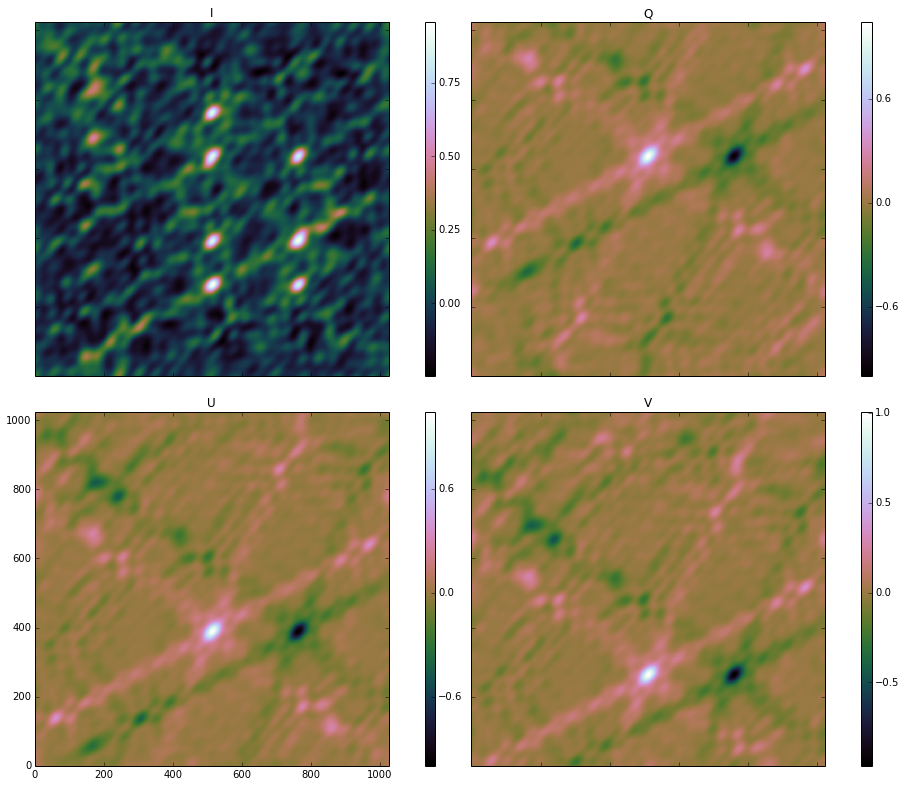

In [221]:
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("I")
im = grid[0].imshow(I, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("Q")
im = grid[1].imshow(Q, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
grid[2].set_title("U")
im = grid[2].imshow(U, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[2].cax.colorbar(im)
grid[3].set_title("V")
im = grid[3].imshow(V, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[3].cax.colorbar(im)
plt.show()

# PSF

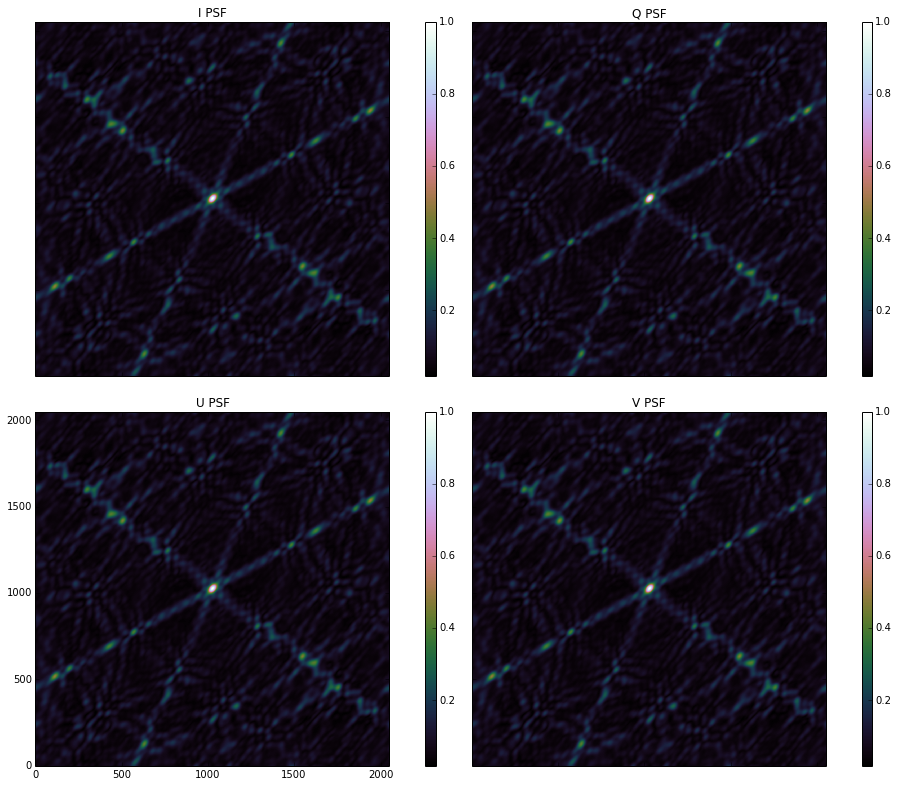

In [222]:
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("I PSF")
im = grid[0].imshow(I_PSF, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("Q PSF")
im = grid[1].imshow(Q_PSF, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
grid[2].set_title("U PSF")
im = grid[2].imshow(U_PSF, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[2].cax.colorbar(im)
grid[3].set_title("V PSF")
im = grid[3].imshow(V_PSF, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[3].cax.colorbar(im)
plt.show()

# Clean

In [228]:
print "Cleaning I..."
I_clean,I_residue,I_restored,I_convmodel, _, _, _, _, _, _, _, _ , _, _, _, _ = CLEAN_HOG(I,Q,U,V,I_PSF,mode="I")
print "\t ...done"
print "Cleaning Q+Ui..."
_, _, _, _, Q_clean, Q_residue, Q_restored, Q_convmodel, U_clean, U_residue, U_restored, U_convmodel, _, _, _, _ = CLEAN_HOG(I,Q,U,V,I_PSF,mode="Q+iU")
print "\t ...done"


Cleaning I...
Threshold set at  0.191309195327
Done cleaning for mode I after 76 iterations. Now restoring...
	 ...done
Cleaning Q+Ui...
Threshold set at  0.209215099552
Done cleaning for mode Q+iU after 79 iterations. Now restoring...
	 ...done


## Cleaned I

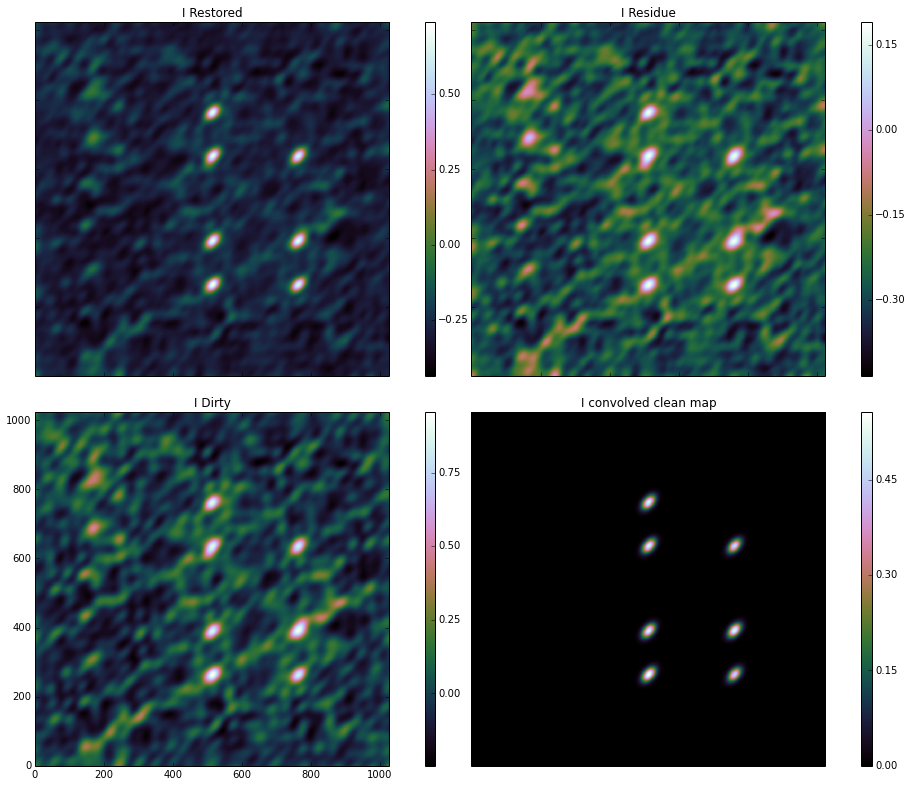

In [229]:
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("I Restored")
im = grid[0].imshow(I_restored, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("I Residue")
im = grid[1].imshow(I_residue, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
grid[2].set_title("I Dirty")
im = grid[2].imshow(I, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[2].cax.colorbar(im)
grid[3].set_title("I convolved clean map")
im = grid[3].imshow(I_convmodel, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[3].cax.colorbar(im)
plt.show()

## Cleaned Linear

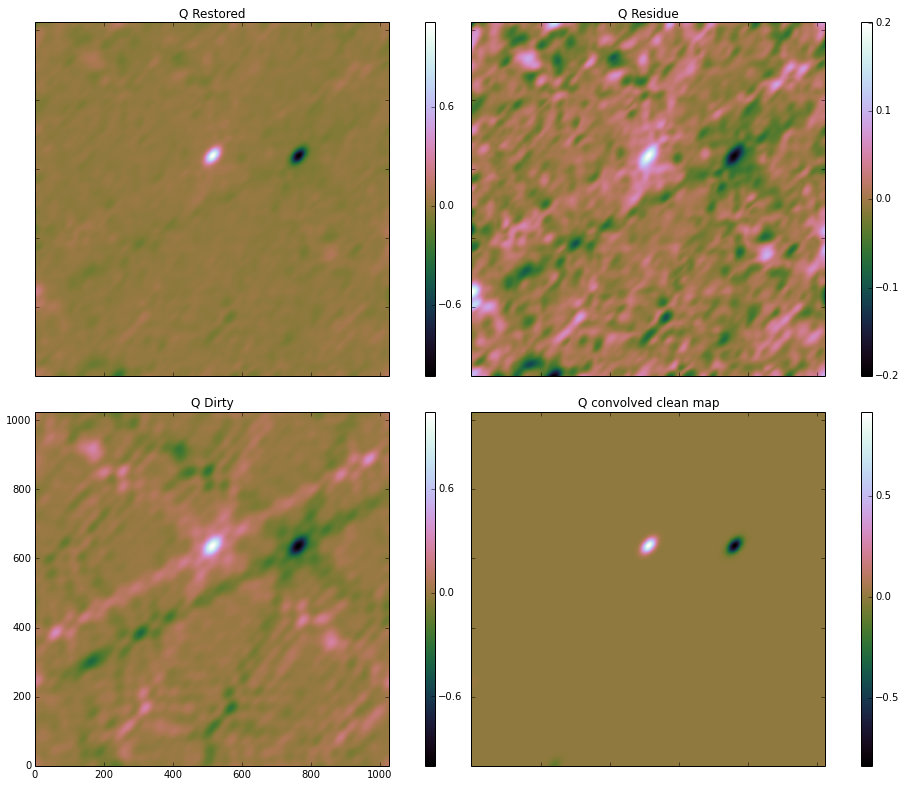

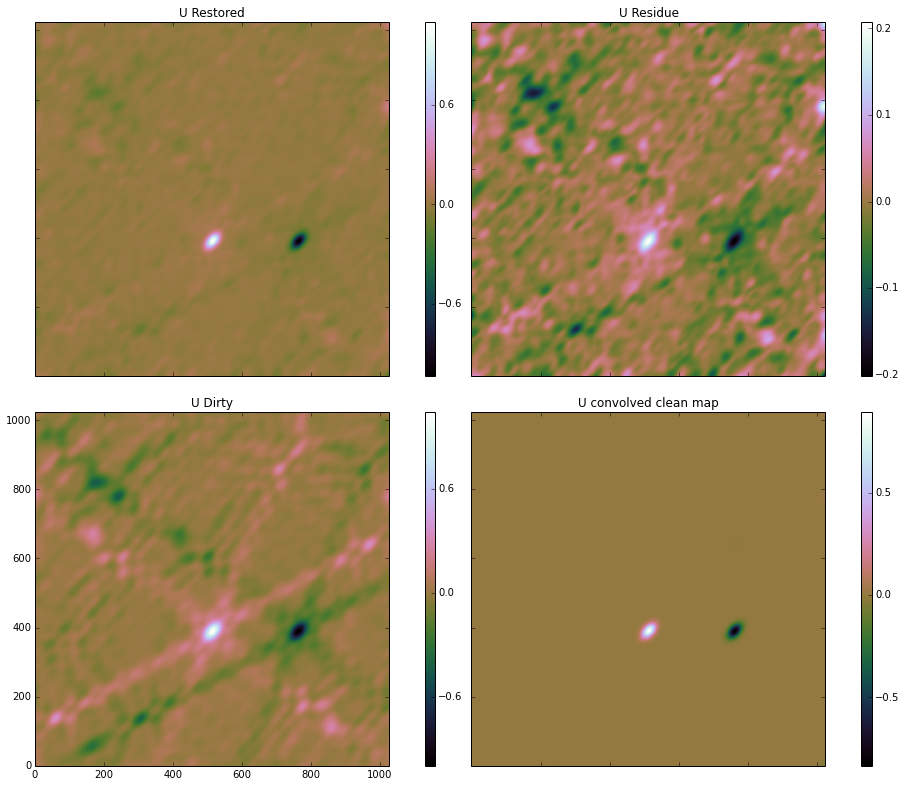

In [230]:
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("Q Restored")
im = grid[0].imshow(Q_restored, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("Q Residue")
im = grid[1].imshow(Q_residue, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
grid[2].set_title("Q Dirty")
im = grid[2].imshow(Q, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[2].cax.colorbar(im)
grid[3].set_title("Q convolved clean map")
im = grid[3].imshow(Q_convmodel, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[3].cax.colorbar(im)
plt.show()

F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("U Restored")
im = grid[0].imshow(U_restored, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("U Residue")
im = grid[1].imshow(U_residue, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
grid[2].set_title("U Dirty")
im = grid[2].imshow(U, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[2].cax.colorbar(im)
grid[3].set_title("U convolved clean map")
im = grid[3].imshow(U_convmodel, origin="lower", interpolation="nearest", cmap="cubehelix")
grid[3].cax.colorbar(im)
plt.show()